## Importing packages:

In [1]:
import pandas as pd 
import numpy as np
from unidecode import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sqlalchemy as sqla

## Extract table from SQL database and data cleaning:

In [2]:
sqlite_file='../data/covid.sqlite'
covid_engine = sqla.create_engine('sqlite:///'+sqlite_file)
df = pd.read_sql_query("select * from date_table where date = '20210524'",con = covid_engine,index_col = 'Country Name')
df = df.replace(r'^\s*$', np.nan, regex=True)# replace all blank cells with Null

In [3]:
df2 = df[['Total Cases','Total Deaths','Total Recovered','Active Cases','Serious Critical','Total Tests','Tot cases/1M pop','Deaths/1M pop','Population','Continent']].copy()
df2.dropna(inplace=True)
%run ../code/dataframe_clean.py
cleaned_df = numeric_col_clean(df2)

## Question of Interest 1: Which countries have lowest case fatality rate? and which countries have highest case fatality rate?

For below interative visualization, there are two sliders, one represents the maximum number of total cases per 1 milion.The other represents the maximum number of total deaths per 1 milion. Each point on the plot represents one country, each country has a unique color. Clicking on the point the information such as total cases per 1 milion population, total deaths per 1 milion population, country name and case fatality rate for that country will be shown.Countries that satisifies conditions according to the value of two sliders will be shown on the interactive plots. 

## Interactive visualization

In [4]:
interact_data = cleaned_df.copy()
interact_data = interact_data.reset_index()
countries = interact_data['Country Name'].unique()
interact_data = interact_data.set_index(['Country Name'])

In [5]:
from bokeh.io import output_notebook
output_notebook()
from bokeh.plotting import show,figure,ColumnDataSource
from ipywidgets import widgets,interact
import random


def get_plot(max_death1m,max_case1m):
    '''
    This function is able to plot the scatter plot according to the range of x and y value. x is total deaths per 1 milion population
    y is total cases per 1 milion population.The range of x and y is dependent on the input of this function which is the maximum number 
    of x and maximum number of y.
    Each point on the scatter plot is able to show its corresponding country name,value of x,value of y and case fatality rate.
    '''
    filtered_countries=[]
    for country in countries:
        if (interact_data.loc[country]['Deaths/1M pop']<=max_death1m) and (interact_data.loc[country]['Tot cases/1M pop']<=max_case1m):
            filtered_countries.append(country)
    data_source=get_datasource(filtered_countries)
    TOOLTIPS = [('Country','@countries'),('death per 1M','@x'),('cases per 1M','@y'),('case fatality rate','@division')]
    plot = figure(title = 'Total cases per 1 milion populaton VS Deaths per 1 milion populaton',
                 x_axis_label = 'Deaths per 1 milion populaton',
                 y_axis_label = 'Total cases per 1 milion populaton',
                 tooltips = TOOLTIPS,
                 plot_width=800,
                 plot_height=500)
    plot.circle('x','y',source = data_source,size=20,color='color',alpha=0.5)
    return plot


def get_random_color():
    '''
    This function randomly generates the color of point on the scatter plot.
    '''
    rgbl = (random.randrange(0,120),random.randrange(0,120),random.randrange(0,120)) #make points obvious to see 
    return rgbl

def get_datasource(filtered_countries):
    '''
    This function takes in the filtered_countries which is a list of country names. 
    It extract the corresponding country name, x value(Total deaths per 1 milion population), y value(Total cases per 1 milion population) 
    and case fatality rate for countries inside the filtered_countries list.
    '''
    return ColumnDataSource(data = dict(color = [get_random_color()for _ in filtered_countries],
                                        countries = filtered_countries,
                                       x = [interact_data.loc[country]['Deaths/1M pop'] for country in filtered_countries],
                                       y = [interact_data.loc[country]['Tot cases/1M pop'] for country in filtered_countries],
                                       division = [interact_data.loc[country]['Deaths/1M pop']/interact_data.loc[country]['Tot cases/1M pop'] for country in filtered_countries]))




max_death1m = interact_data['Deaths/1M pop'].max()
max_case1m = interact_data['Tot cases/1M pop'].max()
max_death1m_slider = widgets.IntSlider(value = max_death1m,min = 0,max=max_death1m,step = 500,
                                       description = 'max.death1m',orientation = 'horizontal')
max_case1m_slider = widgets.IntSlider(value = max_case1m,min = 0,max=max_case1m,step = 20000,
                                       description = 'max.case1m',orientation = 'vertical')
@interact(max_death1m=max_death1m_slider,max_case1m=max_case1m_slider)

def get_stas(max_death1m,max_case1m):
    '''
    This function takes in the maximum number of x and y values. And it returns the coresponding plots and two sliders 
    that together makes an interactive plot.
    '''
    show(get_plot(max_death1m,max_case1m))


Loading BokehJS ...

interactive(children=(IntSlider(value=3069, description='max.death1m', max=3069, step=500), IntSlider(value=17…

## Conclusion for question 1:

We set the total cases per 1 milion population to max(160000) and set the total deaths per 1 milion population to minimum(500) in order to find the countries with lowest case fatality rate.Then, from the interactive plot we see that
Qatar, Maldives and Bahrain have lowest case fatality rate that is below 0.004. We set the total cases per 1 milion population to min(20000) and set the total deaths per 1 milion population to max(3000) in order to find the countries with highest case fatality rate.From the interactive plot, we see that Mexico has the highest case fatality rate which is around 0.0925. 

## Question of interest 2 :Which continent has high case fatality rate in an overall sense? And which continent has low case fatality rate in an overall sense?

In [6]:
cleaned_df['recovered rate'] = cleaned_df['Total Recovered']/cleaned_df['Total Cases']#Total Recovered / Total Cases
cleaned_df['case fatality rate'] = cleaned_df['Total Deaths']/cleaned_df['Total Cases']#Total Deaths / Total Cases
cleaned_df['mortality rate'] = cleaned_df['Total Deaths']/cleaned_df['Population']#Total Tests/population
cleaned_df['infected rate'] =  cleaned_df['Total Cases']/cleaned_df['Population']#total Cases / population

For below plots, we have 148 countries and each country have their own corresponding Total Deaths per 1 milion people and Total cases per 1 milion people. We put Total cases per 1 milion people on the x-axis and Total Deaths per 1 milion people on the y-axis. Each country have their own color according to the continent they belong to. Each continent has their own linear regression line that describes the general trend among countries that belong to the same continent.

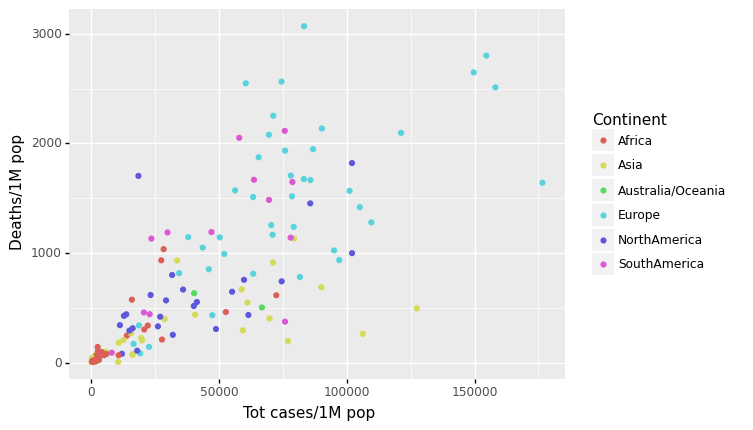

<ggplot: (8793115450709)>

In [7]:
import plotnine as p9
gg = p9.ggplot(cleaned_df)
gg += p9.aes(x='Tot cases/1M pop',y='Deaths/1M pop',color = 'Continent')
gg += p9.geom_point()
gg

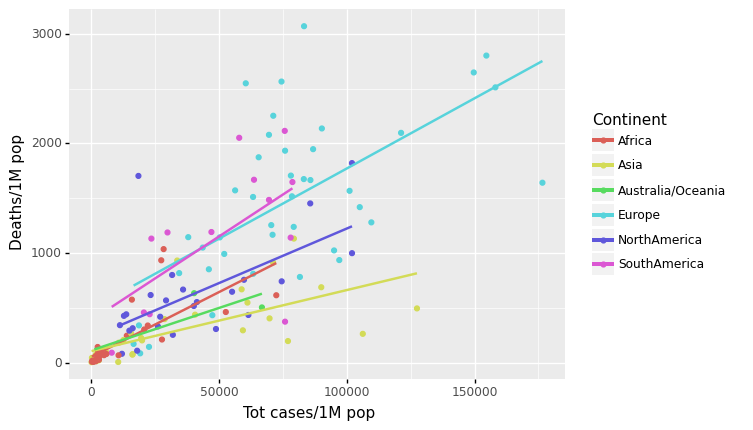

<ggplot: (8793064977806)>

In [8]:
gg+p9.stat_smooth(mapping=p9.aes(x='Tot cases/1M pop',y='Deaths/1M pop'),method='lm',se=False)

## Conclusion for question 2:

From the above plot we see that South America and Africa have higher case fatality rate in general trend. The reason is that the linear regression line is tilted upward. They intersect with other continent's liner regression line and finally rise above them. Also, from the plot we see that Asia has lower case fatality rate in general trend since the linear regression line for Asia is tilted downward compared to other linear regression lines. All other linear regression line have greater angles between the line and x-axis. 

## Question of interest 3 :Which continent has relatively high serious critical proportion in an overall sense?

For below plots, we have 148 countries and each country have their own corresponding number of Serious Critical per 1 milion people and Total cases per 1 milion people. We put Total cases per 1 milion people on the x-axis and the number of Serious Critical per 1 milion people on the y-axis. Each country have their own color according to the continent they belong to.Each continent has their own linear regression line that describes the general trend among countries that belong to the same continent.

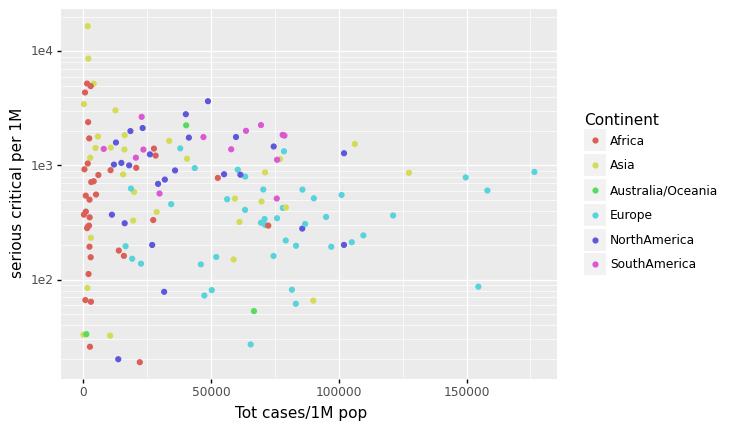

<ggplot: (8793115450763)>

In [9]:
import plotnine as p9
cleaned_df['serious critical per 1M'] = (cleaned_df['Serious Critical']/cleaned_df['Total Cases']) *1000000

gg = p9.ggplot(cleaned_df)
gg += p9.aes(x='Tot cases/1M pop',y='serious critical per 1M',color = 'Continent')
gg += p9.geom_point()
gg += p9.scale_y_log10()
gg

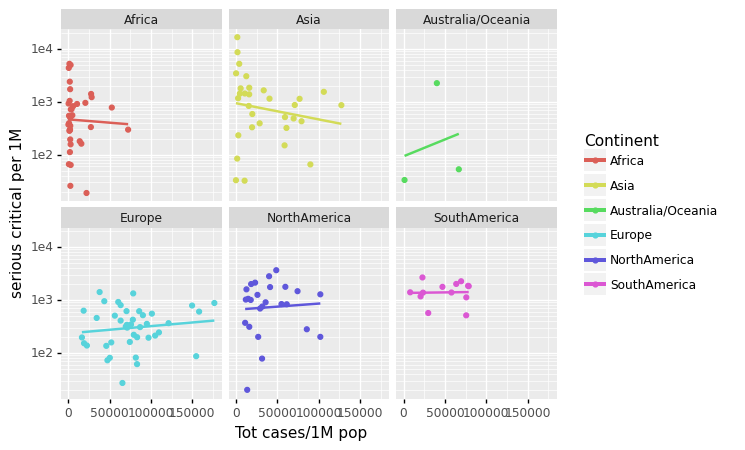

<ggplot: (8793015262838)>

In [10]:
gg + p9.facet_wrap('~Continent')\
+p9.stat_smooth(mapping=p9.aes(x='Tot cases/1M pop',y='serious critical per 1M'),method='lm',se=False)

## Conclusion for question3:

From the above facet plot we see that South America have the highest serious critical proportion which is above 1000 serious criticals per 1 milion people.The linear regression line is nearly horizontal which means there is no much difference for the serious critical proportion among countries in South America. The second highest are North America and Asia.However, the general trend for Asia is decreasing which means the variance for Asia is high and there are large number of countries have relatively low serious critical proportions. But, North America's general trend is gradually increasing which means countries in North America have relatively lower variance compared to Asia and the overall serious critical proportion is high.

In [11]:
grouped_continent = cleaned_df.groupby(['Continent']).mean()
grouped_continent = grouped_continent.reset_index()
grouped_continent

,Continent,Total Cases,Total Deaths,Total Recovered,Active Cases,Serious Critical,Total Tests,Tot cases/1M pop,Deaths/1M pop,Population,recovered rate,case fatality rate,mortality rate,infected rate,serious critical per 1M
0,Africa,1.252995e+05,3419.257143,1.133159e+05,8564.314286,78.142857,1.225138e+06,9904.857143,169.228571,2.875626e+07,0.895425,0.020713,0.000169,0.009905,953.282027
1,Asia,1.471441e+06,18693.709677,1.335992e+06,116755.419355,1016.967742,2.443635e+07,33856.000000,292.677419,1.307674e+08,0.896086,0.019313,0.000293,0.033856,1859.969015
2,Australia/Oceania,1.644267e+04,353.000000,1.605067e+04,39.000000,1.000000,5.983774e+06,36054.666667,390.333333,8.686356e+06,0.980622,0.017855,0.000390,0.036055,777.844334
3,Europe,1.113824e+06,25643.048780,1.033383e+06,54797.756098,437.048780,2.035602e+07,76695.512195,1472.487805,1.791773e+07,0.926361,0.019655,0.001473,0.076696,418.409018
4,NorthAmerica,1.581212e+06,35456.720000,1.290209e+06,255546.280000,587.400000,2.123933e+07,39703.520000,622.840000,2.297171e+07,0.791035,0.019380,0.000623,0.039704,1130.759549
5,SouthAmerica,2.152858e+06,58468.923077,1.943719e+06,150669.769231,2264.384615,8.911708e+06,50075.692308,1151.846154,3.338080e+07,0.843052,0.024422,0.001152,0.050076,1532.958051


## Question of interest 4: Which continent has the highest infected rate? And which continent has the lowest infected rate?

For the below barplot, we plot both infected rate and case fatality rate for each continent together. And we use different color to represent each rate. On the x-axis, there is the name for each continent. On the y-axis, it indicates the percentage for infected population and case fatality.

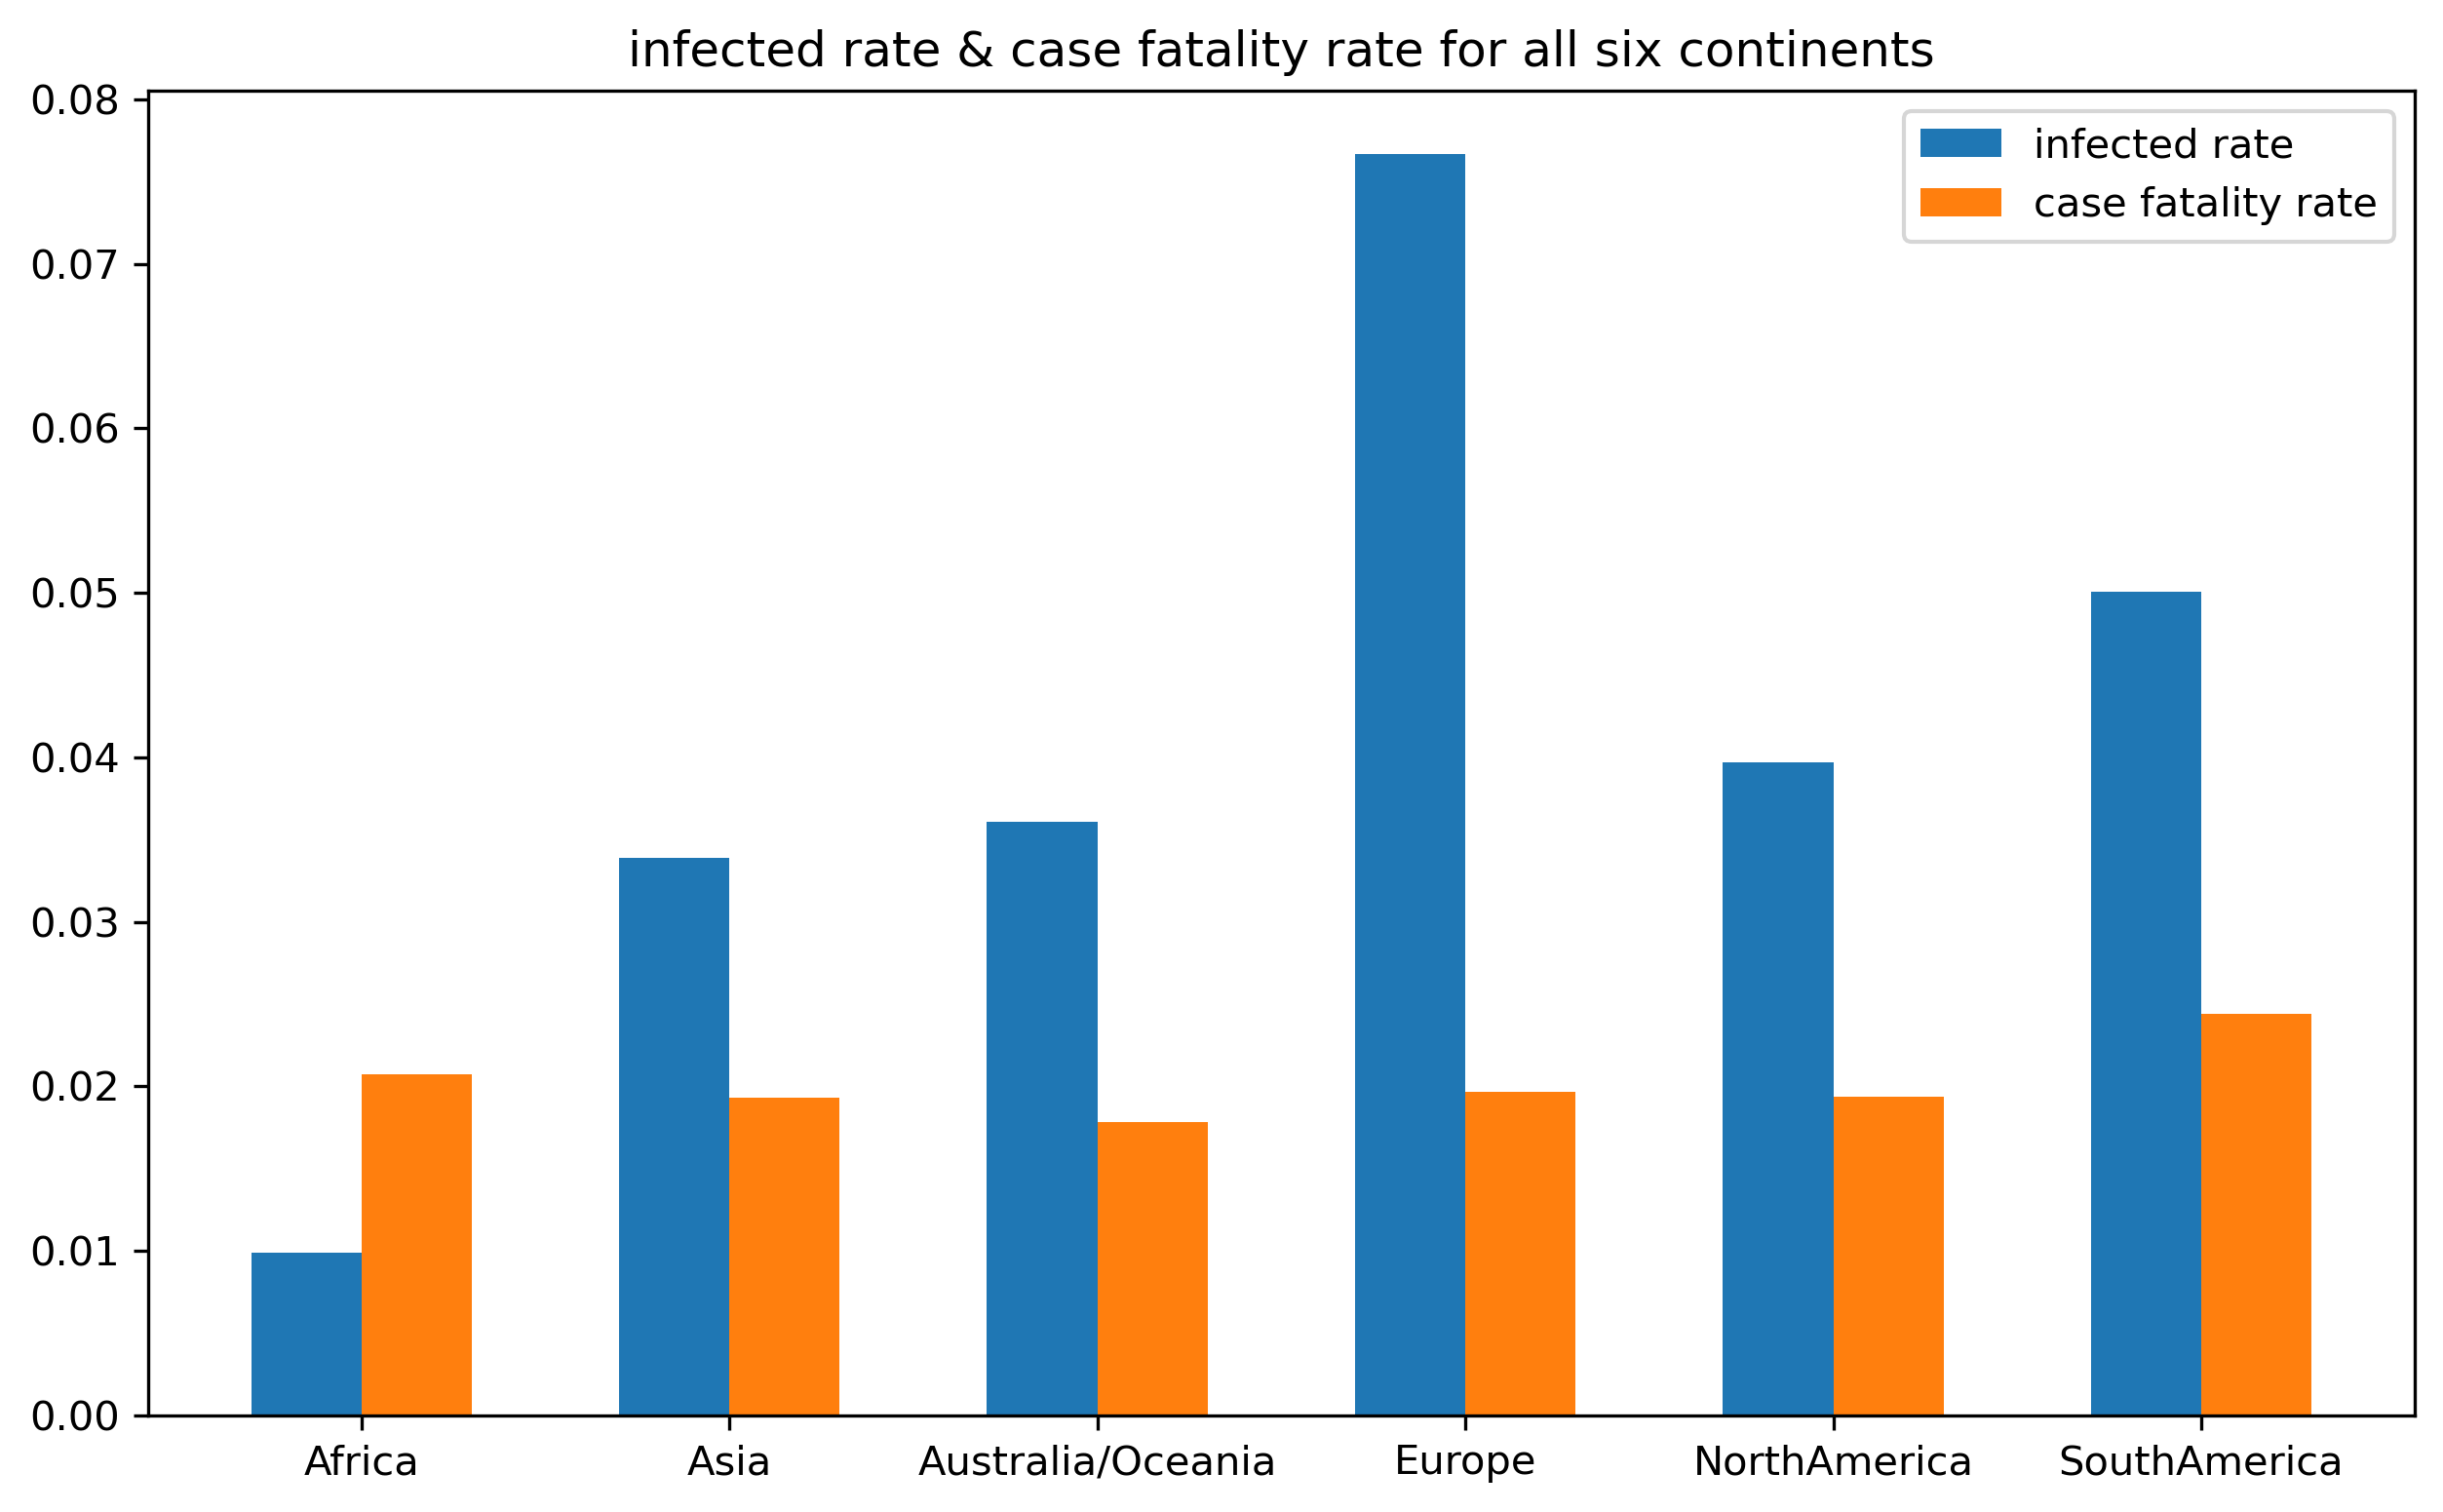

In [12]:
plt.figure(figsize=(10,6),dpi=300)
pos = np.arange(6)
width = 0.3
plt.bar(pos-width/2,grouped_continent['infected rate'],width,label='infected rate')
plt.bar(pos+width/2,grouped_continent['case fatality rate'],width,label='case fatality rate')
ax = plt.gca()
plt.xticks(pos)
ax.set_xticklabels(grouped_continent['Continent'])
plt.title('infected rate & case fatality rate for all six continents')
plt.legend()
plt.show()

## Conclusion for question 4: 

From the barplot we see that, Europe has the highest infected rate which is around 8%. Africa has the lowest infected rate which is 1%. 

## Question of interest 5: Which continent has the highest recovered rate and which has the lowest recovered rate? What about mortality rate?

For below barplots, we put continent names on the x-axis and we put recovered rate on the y-axis for the first barplot. Then, we put mortality rate on the y-axis for the second barplot. We use the same color to represent each continent for both barplots.

Text(0.5, 1.0, 'recovered rate for all six continents')

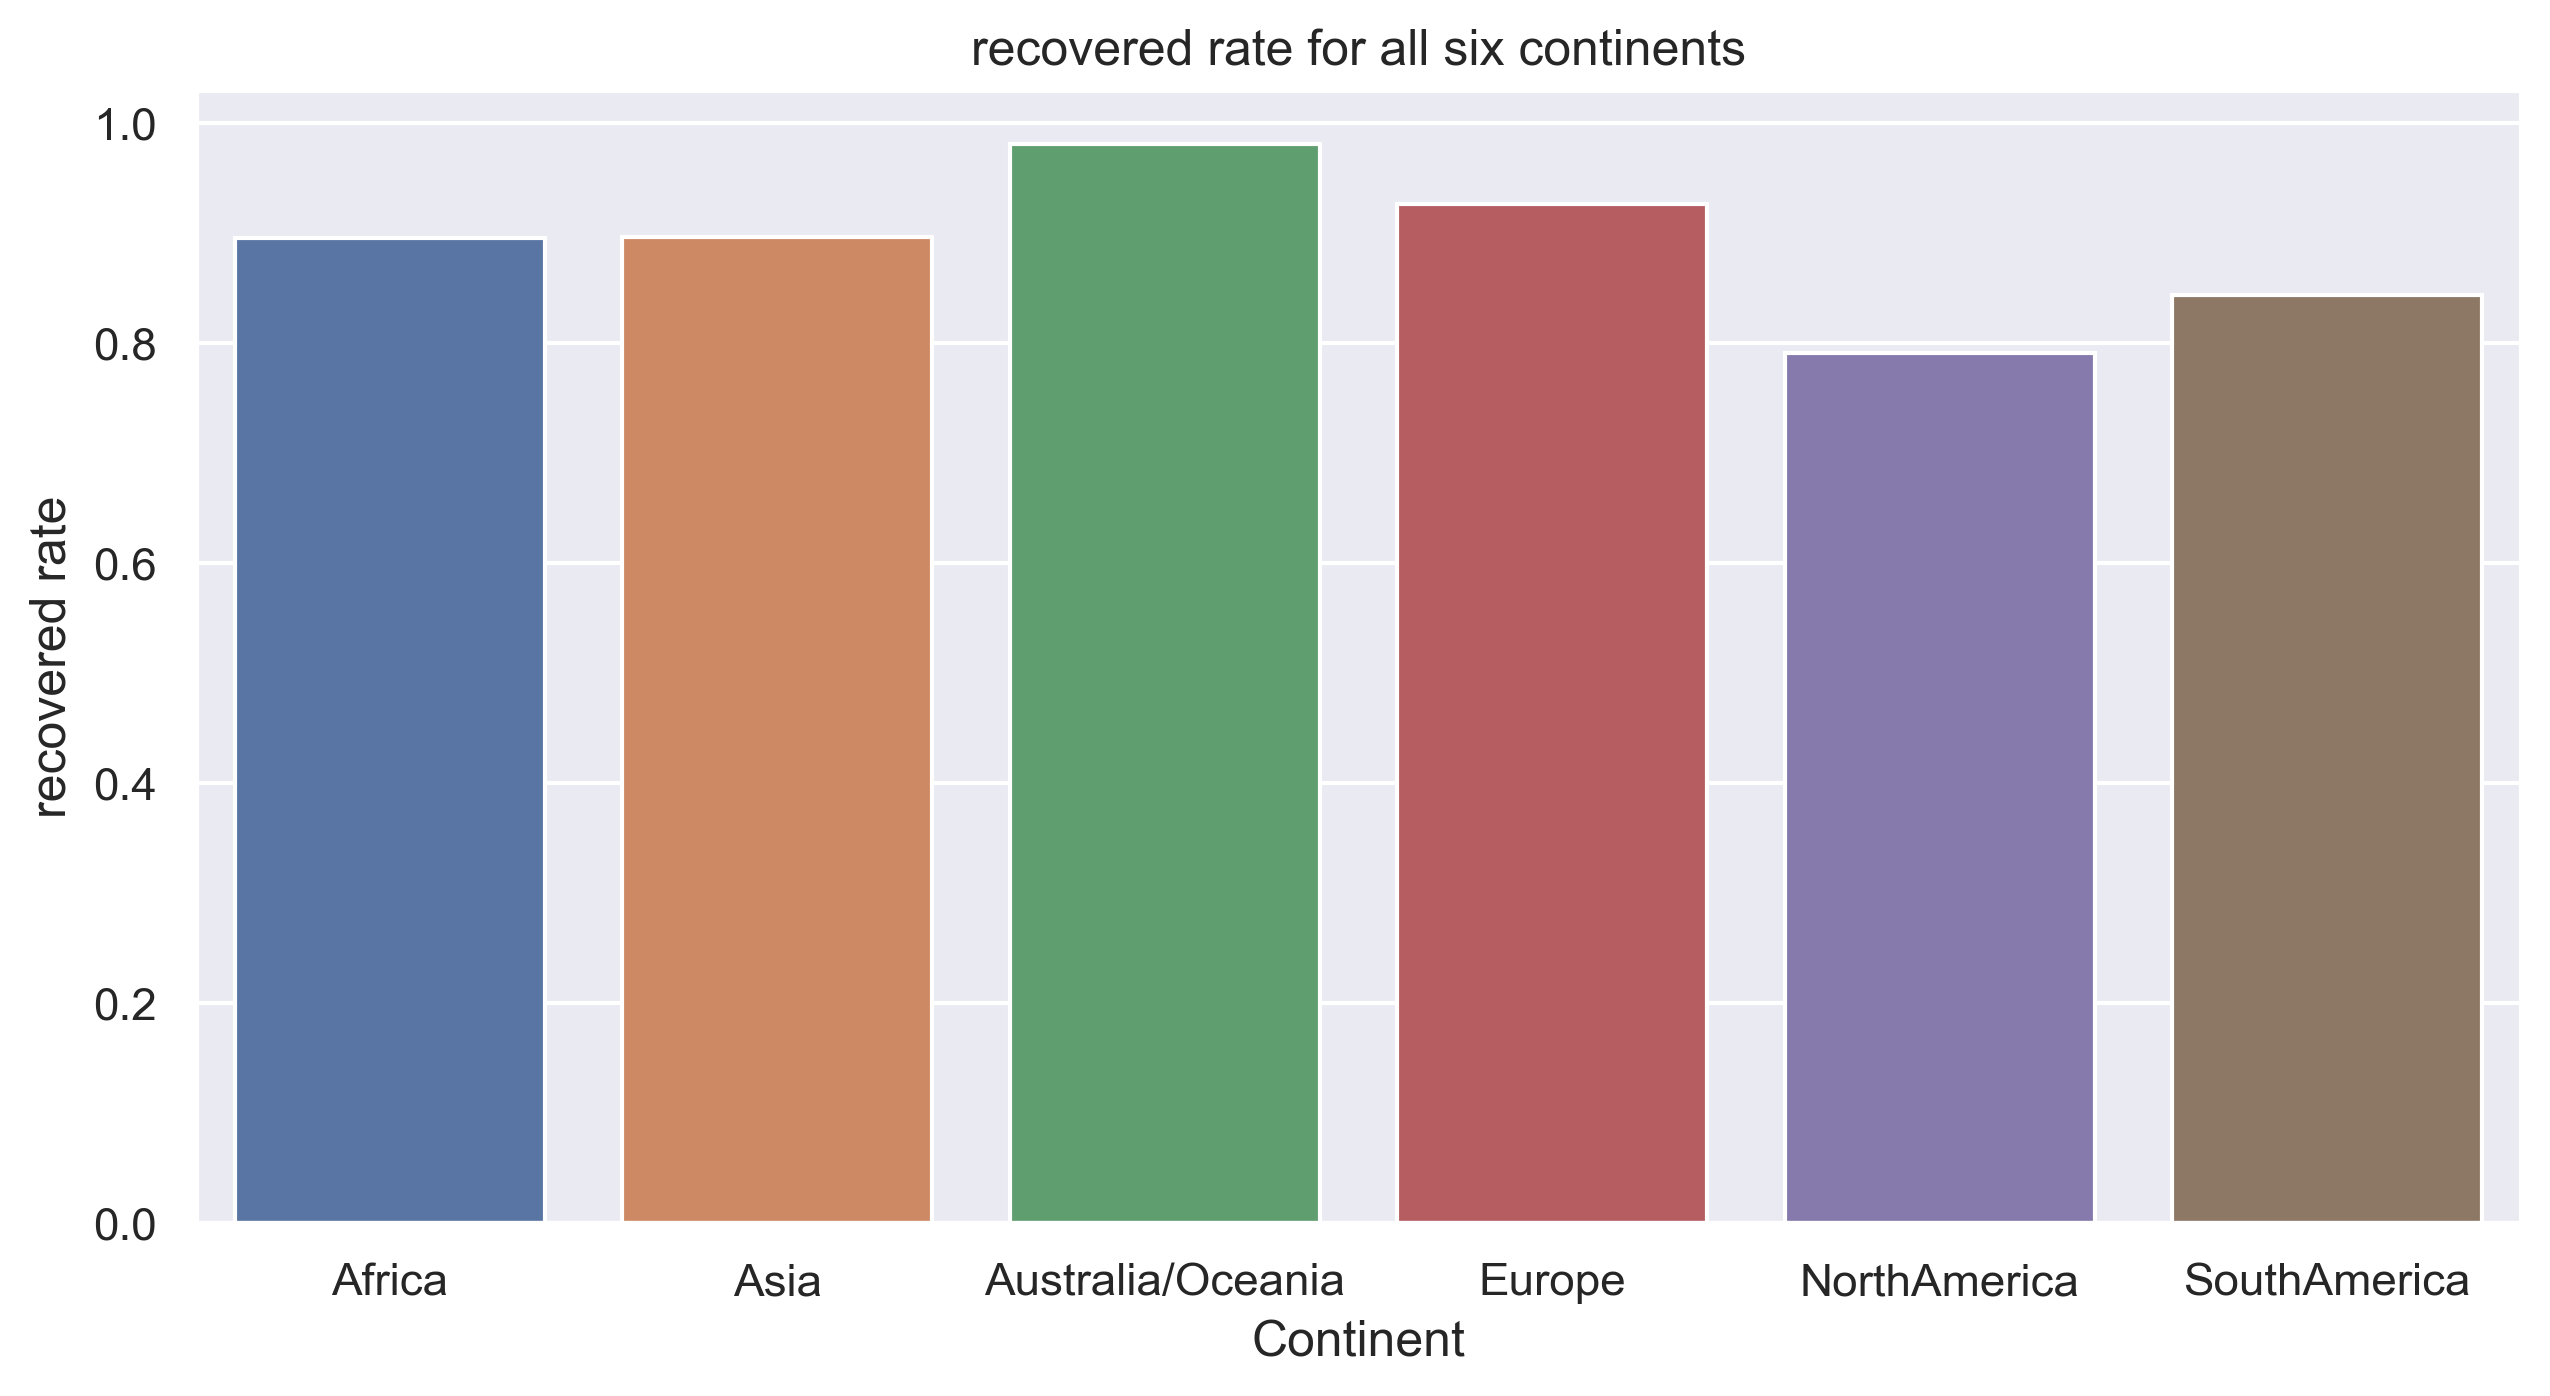

In [13]:
sns.set()
plt.figure(figsize=(10,5),dpi=300)
ax = sns.barplot(x = 'Continent',y = 'recovered rate',data = grouped_continent)
plt.title('recovered rate for all six continents')

Text(0.5, 1.0, 'mortality rate for all six continents')

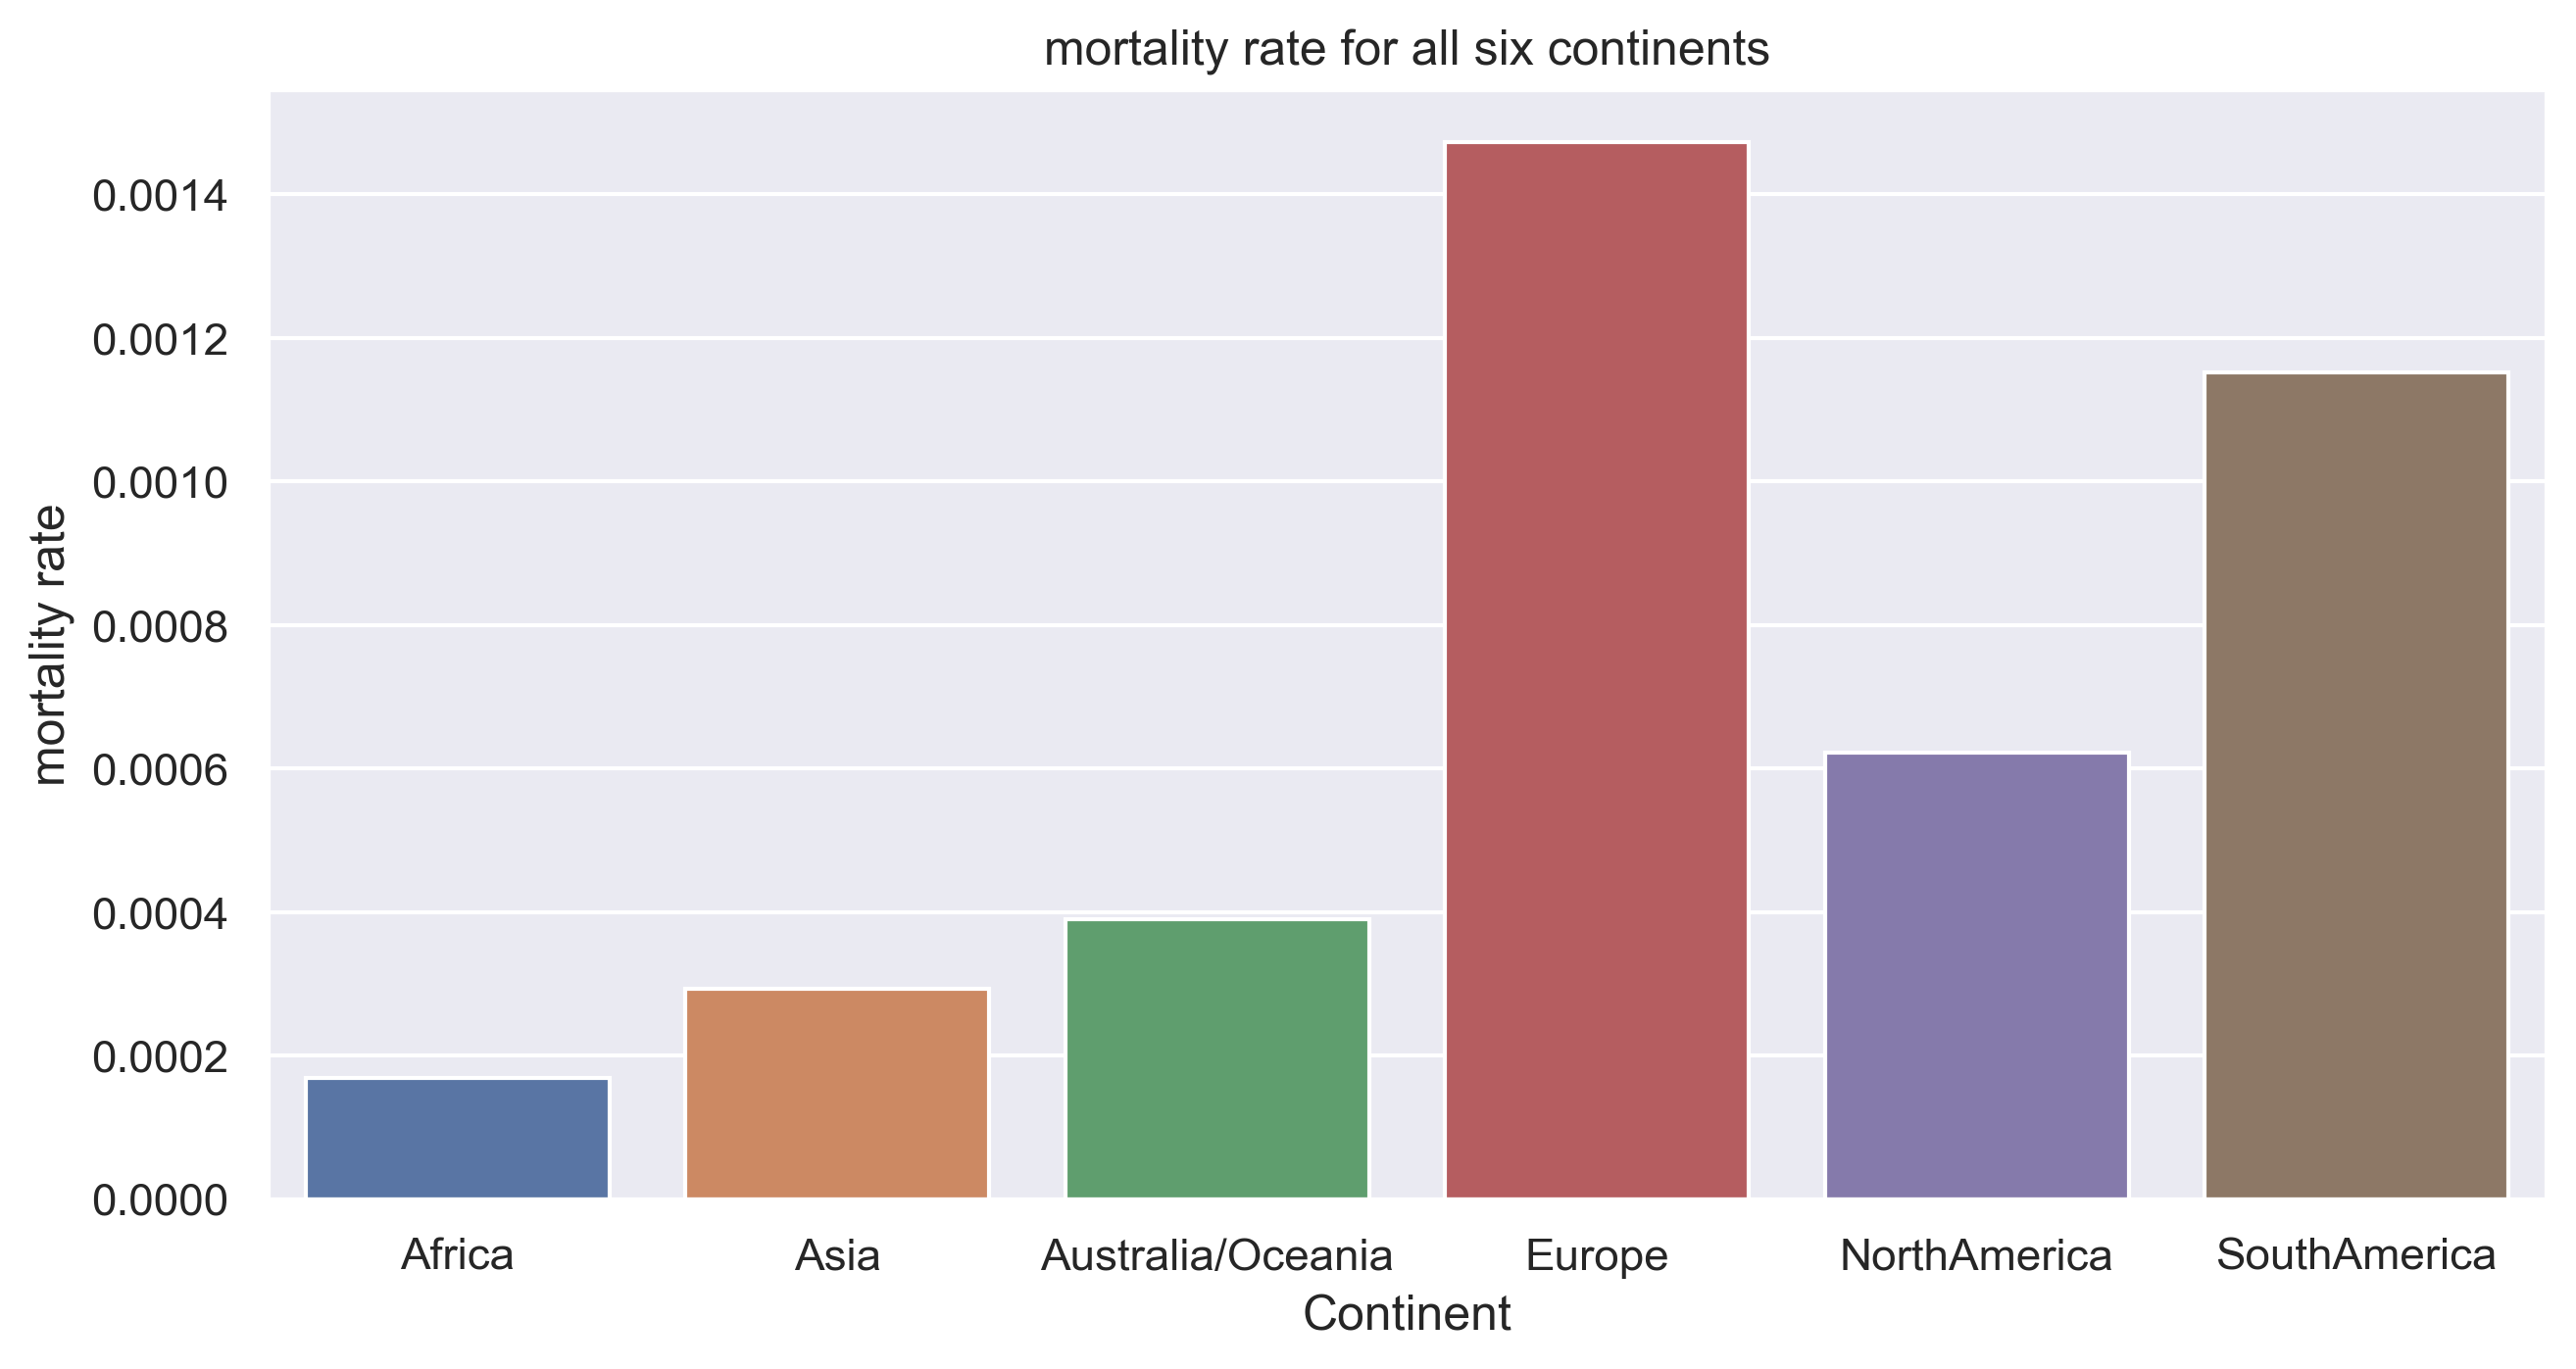

In [14]:
sns.set()
plt.figure(figsize=(10,5),dpi=300)
ax = sns.barplot(x = 'Continent',y = 'mortality rate',data = grouped_continent)
plt.title('mortality rate for all six continents')

## Conclusion for question 5: 

For recovered rate, Austrlia and Europe have the highest recovered rate. Austrlia's recovered rate is nearly 100%, and Europe is around 90%. North America has the lowest recovered rate which is below 80%.<br>
For mortality rate, Europe has the highest which is around 0.14%. South America has the second highest which is around 0.11%. Africa has the lowest mortality rate which is below 0.02%.

## Question of interest 6: For all Covid-19 cases, which continent has the highest proportion? And for all Covid-19 deaths, which continent has the highest death proportion? 

Below are two pie charts, area on the pie chart represent the proportion. Each continent has their own color.The continent with highest proportion on both pie charts will highlighted.Each continent's name is beside its corresponding part on the pie chart. The first pie chart summarizes the total cases distribution. The second pie chart summarizes total deaths distribution.

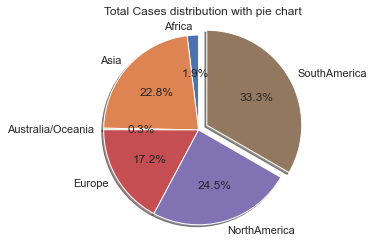

In [15]:
labels = grouped_continent['Continent']
Total_Cases = grouped_continent['Total Cases']
split = [0,0,0,0,0,0.1]
fig1,ax1 = plt.subplots()
ax1.pie(Total_Cases, labels=labels,explode = split, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Total Cases distribution with pie chart')
plt.show()

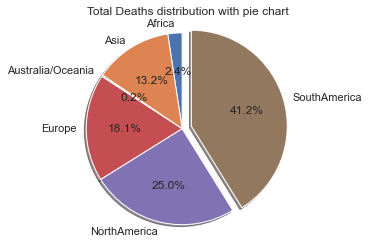

In [16]:
labels = grouped_continent['Continent']
Total_Death = grouped_continent['Total Deaths']
split = [0,0,0,0,0,0.1]
fig1,ax1 = plt.subplots()
ax1.pie(Total_Death, labels=labels,explode = split, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Total Deaths distribution with pie chart')
plt.show()

## Conclusion for question 6:

For the first pie chart, South America has the highest percentage of total cases which is around 33.3%. Australia/Oceania and Africa have lowest percentage which is below 2%. For the second pie chart, South America has the highest percentage of total deaths which is around 41.2%. Australia/Oceania has the lowest percentage which is around 0.2%. 

## Reading SQL database in chunk to generate time-series plots:

In [17]:
list_a = ['"Asia"','"Africa"','"Europe"','"North America"','"South America"','"Australia/Oceania"']
dataframe_container = []
for i in range(len(list_a)):
    df = pd.read_sql_query("select * from date_table where Continent = {}".format(list_a[i]),con = covid_engine)
    df = df.replace(r'^\s*$', np.nan, regex=True)
    df = df.set_index(['Country Name'])
    df_time_series = df[['New Cases','New Deaths','Continent','date']].copy()
    df_time_series['New Cases'] = df_time_series['New Cases'].replace([np.nan,None], ['0','0'])
    df_time_series['New Deaths'] = df_time_series['New Deaths'].replace([np.nan,None], ['0','0'])
    df_time_series[df_time_series.columns[0]] =  df_time_series.iloc[:,0].apply(lambda x: (unidecode(x).replace('+','')))
    df_time_series[df_time_series.columns[1]] =  df_time_series.iloc[:,1].apply(lambda x: (unidecode(x).replace('+','')))
    df_time_series = numeric_col_clean(df_time_series)
    df_time_series['date'] = pd.to_datetime(df_time_series['date'],format='%Y%m%d')
    dataframe_container.append(df_time_series.groupby(['date']).mean())

For below six plots, each plot represents a continent and their average new cases and new deaths from the date 5/24 to the date 6/3. On the primary y-axis, it is the average number of new cases. On the secondary y-axis, it is the average number of new deaths. On the x-axis, it is the date.On each plot, the blue line represents the trend for new cases, and the orange line represents the trend for new deaths.

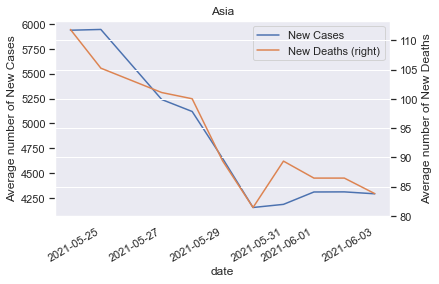

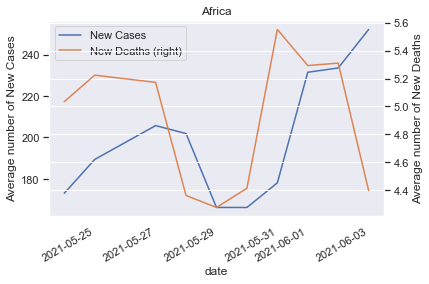

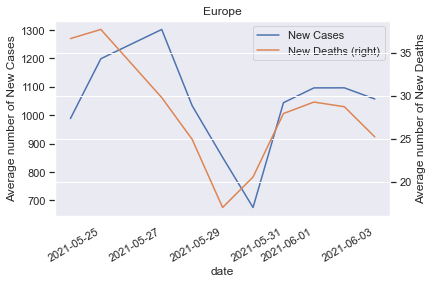

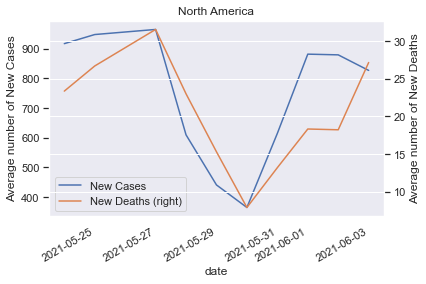

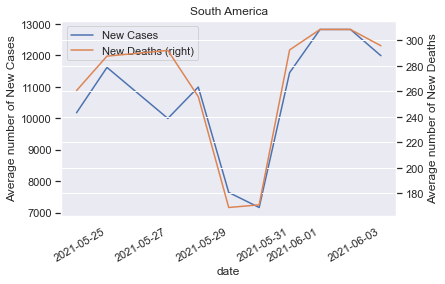

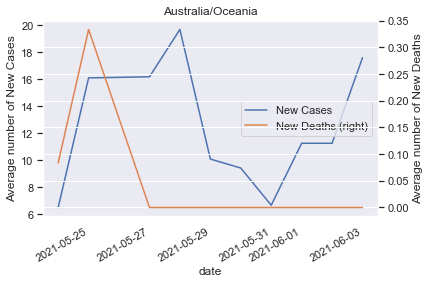

In [18]:
continent_name = ["Asia","Africa","Europe","North America","South America","Australia/Oceania"]
for i in range(6):
    ax = dataframe_container[i].plot(secondary_y=["New Deaths"])
    ax.set_ylabel("Average number of New Cases")
    ax.right_ax.set_ylabel("Average number of New Deaths")
    plt.title(continent_name[i])

For majority continent, we see that the trend for new cases and new deaths are similar. They rise and fall at similar pace.